# Bigraph-Builder Demo

In [2]:
from biosimulator_processes.biosimulator_builder import BiosimulatorBuilder 

CobraProcess registered successfully.


/Users/alex/miniconda3/envs/experiment/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:382: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


CopasiProcess registered successfully.
SmoldynProcess not available. Error: 
PLEASE NOTE: Smoldyn is not correctly installed on your system which prevents you from using the SmoldynProcess. Please refer to the README for further information on installing Smoldyn.
TelluriumProcess registered successfully.
DeterministicTimeCourseParameterScan registered successfully.


## Initialize the builder

In [3]:
b = BiosimulatorBuilder()

In [5]:
print(b.list_processes())

['copasi', 'ram-emitter', 'console-emitter', 'parameter_scan', 'cobra', 'tellurium']


In [10]:
def add_single_process():
    process_type = input(f'Please enter one of the following process types that you wish to add:\n{b.list_processes()}\n:')
    builder_node_name = input('Please enter the name that you wish to assign to this process: ')
    process_kwargs = input('Please enter the process configuration keyword arguments')
    visualize = input('Do you wish to visualize this addition after (y/N): ')
    b[builder_node_name].add_process(name=process_type, **dict(process_kwargs))
    b.connect_all()
    if 'N' in visualize:
        b.visualize();
    

In [11]:
add_single_process()

Please enter one of the following process types that you wish to add:
['copasi', 'ram-emitter', 'console-emitter', 'parameter_scan', 'cobra', 'tellurium']
: copasi
Please enter the name that you wish to assign to this process:  copasiA
Please enter the process configuration keyword arguments {'model': {'model_filepath': 'fp'}}
Do you wish to visualize this addition after (y/N):  y


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [19]:
process_kwargs = input('Please enter the process configuration keyword arguments')
process_args = process_kwargs.split('=')
input_kwargs = {}
input_kwargs[process_args[0]] = process_args[1]

input_kwargs


Please enter the process configuration keyword arguments a=23


{'a': '23'}

In [9]:
b['event_process'].add_process(
    name='GillespieEvent',
    kdeg=1.0,  # kwargs fill parameters in the config
)

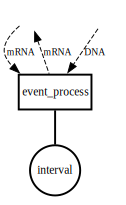

In [10]:
# visualize shows the process with its disconnected ports
b.visualize()

### print ports

In [11]:
b['event_process'].interface(True)

{ '_inputs': { 'DNA': {'A gene': 'float', 'B gene': 'float'},
               'mRNA': 'map[float]'},
  '_outputs': {'mRNA': 'map[float]'}}


### connect ports using connect_all
`Builder.connect_all` connects ports to stores of the same name.

In [12]:
b.connect_all(append_to_store_name='_store')
b

Builder({ 'event_process': { '_type': 'process',
                     'address': 'local:GillespieEvent',
                     'config': {'kdeg': 1.0, 'ktsc': 5.0},
                     'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
                     'instance': <process_bigraph.experiments.minimal_gillespie.GillespieEvent object at 0x106c12dc0>,
                     'interval': 1.0,
                     'outputs': {'mRNA': ['mRNA_store']}}})

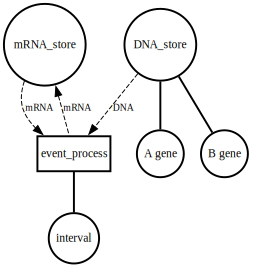

In [13]:
b.visualize()

### add interval process to the config

In [14]:
b['interval_process'].add_process(
    name='GillespieInterval',
)

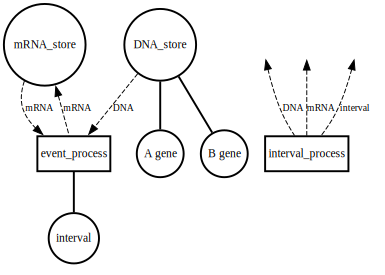

In [15]:
b.visualize()

### connect port to specific target

In [16]:
# to connect a port in a more targeted way, use connect and specify the port and its target path
b['interval_process'].connect(port='interval', target=['event_process', 'interval']) 

# the remaining ports can connect_all
b.connect_all() 

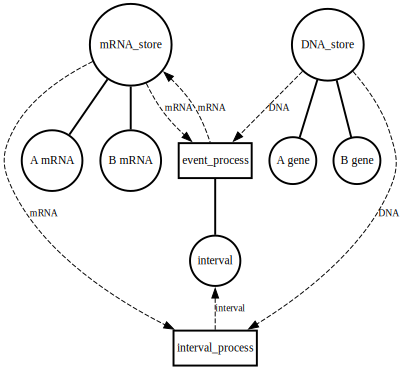

In [17]:
b.visualize()

### check current Builder config

In [18]:
b

Builder({ 'DNA_store': {'A gene': 0.0, 'B gene': 0.0},
  'event_process': { '_type': 'process',
                     'address': 'local:GillespieEvent',
                     'config': {'kdeg': 1.0, 'ktsc': 5.0},
                     'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
                     'instance': <process_bigraph.experiments.minimal_gillespie.GillespieEvent object at 0x106c12dc0>,
                     'interval': 1.0,
                     'outputs': {'mRNA': ['mRNA_store']}},
  'interval_process': { '_type': 'step',
                        'address': 'local:GillespieInterval',
                        'config': {'kdeg': 0.1, 'ktsc': 5.0},
                        'inputs': { 'DNA': ['DNA_store'],
                                    'mRNA': ['mRNA_store']},
                        'instance': <process_bigraph.experiments.minimal_gillespie.GillespieInterval object at 0x106c118b0>,
                        'outputs': {'interval': ['event_process', 'interval']}},
  'm

## Update the initial state

In [19]:
initial_state = {
    'DNA_store': {
        'A gene': 2.0,
        'B gene': 1.0},
}
b.update(initial_state)

## Generate composite from builder config and simulate

In [20]:
composite = b.generate()
composite.run(10)

produced interval: {'interval': 1.21174311488629}
received interval: 1.21174311488629
produced interval: {'interval': 30.66671505248375}


In [21]:
composite

## Retrieve the composite document

In [22]:
doc = b.document()
doc

{'event_process': {'_type': 'process',
  'address': 'local:GillespieEvent',
  'config': {'kdeg': 1.0, 'ktsc': 5.0},
  'inputs': {'mRNA': ['mRNA_store'], 'DNA': ['DNA_store']},
  'outputs': {'mRNA': ['mRNA_store']},
  'interval': 1.0},
 'mRNA_store': {'A mRNA': '1.0', 'B mRNA': '1.0'},
 'DNA_store': {'A gene': '2.0', 'B gene': '1.0'},
 'interval_process': {'_type': 'step',
  'address': 'local:GillespieInterval',
  'config': {'ktsc': 5.0, 'kdeg': 0.1},
  'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
  'outputs': {'interval': ['event_process', 'interval']}},
 'global_time': '0.0'}

### save the document to file

In [23]:
b.write(filename='toy_bigraph')

File 'toy_bigraph' successfully written in 'out' directory.


### load a composite from document
This document represents the full state of the composite, and so can reproduce the previous composite when loaded into a fresh Builder

In [26]:
b2 = Builder(core=core, file_path='out/toy_bigraph.json')
b2

Builder({ 'DNA_store': {'A gene': '2.0', 'B gene': '1.0'},
  'event_process': { '_type': 'process',
                     'address': 'local:GillespieEvent',
                     'config': {'kdeg': 1.0, 'ktsc': 5.0},
                     'inputs': {'DNA': ['DNA_store'], 'mRNA': ['mRNA_store']},
                     'instance': <process_bigraph.experiments.minimal_gillespie.GillespieEvent object at 0x105271250>,
                     'interval': 1.0,
                     'outputs': {'mRNA': ['mRNA_store']}},
  'global_time': '0.0',
  'interval_process': { '_type': 'step',
                        'address': 'local:GillespieInterval',
                        'config': {'kdeg': 0.1, 'ktsc': 5.0},
                        'inputs': { 'DNA': ['DNA_store'],
                                    'mRNA': ['mRNA_store']},
                        'instance': <process_bigraph.experiments.minimal_gillespie.GillespieInterval object at 0x105271130>,
                        'outputs': {'interval': ['event_p

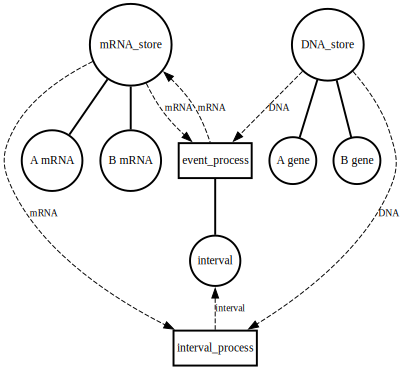

In [27]:
b2.visualize()